# Beiwe

In [55]:
import os, sys, matplotlib, re, io, traceback, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import isnan, nan
from matplotlib.widgets import Slider
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from dateutil.tz import tzlocal
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100000

In [2]:
# Setup all paths and sources
data_path = os.getenv('HOME')+'/projects/beiwe-data/GxXEPM08ZK0GS1gIaLe9YhEn/'
user_list = os.listdir(data_path)
feature_list = ['accel', 'callLog', 'tapsLog', 'usage', 'accessibilityLog', 'gps', 'light', 'powerState', 'textsLog']
user_map = {'Nikolas old ZTE':'16kbga47', 'Nikolas':'1s3g19f7', 'IMH1-Judy':'33kr56tx',
            'IMH2-Amirah':'1tfan3jn', 'Nikolas old Nokia':'8e3ukdwy', 'Praveen':'d35pt9m4',
            'Faye':'drdlfo5c', 'Robert':'gqmrnhvv', 'Xuancong':'hcy9th57'}

df_all, cols_all = {}, {}

In [210]:
# utility functions
def convert_timestamp(timestamp, zone=tzlocal()):
    data = pd.to_datetime(str(timestamp), unit='ms', origin='unix')
    return data.tz_localize('UTC').tz_convert(zone) if zone != 'UTC' else data

def load_csv(fn, **kwargs):
    Ls = open(fn).read().splitlines()
    for i,L in enumerate(Ls):
        if i>0 and not L[0:13].isdigit():
            Ls[i-1] = ''.join(Ls[i-1:i+1])
            Ls[i] = ''
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', '\n'.join([L for L in Ls if L]))
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', txt)
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', txt)
    try:
        ret = pd.read_csv(io.StringIO(txt), **kwargs)
    except:
        traceback.print_exc()
        print('CSV error: in File %s ...'%fn[len(data_path):])
    return ret

def create_df(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = pd.concat([load_csv(fn, error_bad_lines=True) for fn in sorted(glob(dir_path+'/*.csv'))])
#     print(df.columns)
    if 'timestamp' in df.columns:
        df['datetime'] = df.timestamp.apply(convert_timestamp)
    df = df.reset_index(drop=True)
    return df

def load_col(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = load_csv(glob(dir_path+'/*.csv')[0], error_bad_lines=False)
    return df.columns

def date2datetime(d):
    return datetime(d.year, d.month, d.day, tzinfo=tzlocal())

def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(np.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.2,-0.8/b)
    return ret

F1 = {'number of readings':'.count()', 'max value':'.max()', 'min value':'.min()', 'mean value':'.mean()', 'grouped values':''}
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [482]:
d0 = create_df(user_map['Praveen'], 'tapsLog')
d0 = d0.ffill()

In [488]:
SelCol = 'in_app_name'
Interval = '1D'
Extra = 21
figsize = [16,9]

data = d0[['datetime',SelCol]].groupby(pd.Grouper(freq=Interval, key='datetime'))


data0 = data.filter(lambda t:True)
stats = data0[SelCol].value_counts()
N_cls_present = stats.size
N_cls = min(Extra, N_cls_present)
selected_cls = stats.index.tolist()[:N_cls]
if N_cls_present > N_cls:
    data0[SelCol] = data0[SelCol].apply(lambda t:t if t in selected_cls else '<Others>')
    selected_cls += ['<Others>']
    N_cls += 1

data = data0.groupby(pd.Grouper(freq=Interval, key='datetime'))
data.reset_index()
# map_null = lambda t:t if len(t) else {selected_cls[0]:0}
# data = pd.DataFrame.from_dict({g[0]:map_null(g[1][SelCol].value_counts()) for g in data}, orient='index').fillna(0)
# xy_plot = data[selected_cls[::-1]].plot.bar(stacked=True, rot=45, figsize=figsize, color=generate_colormap(N_cls))
# xy_plot.set_xticklabels(xy_plot.get_xticklabels(), ha='right')
# xy_plot.get_figure().subplots_adjust(right=0.8)
# xy_plot.legend(loc='center left', prop={'size': 10}, bbox_to_anchor=(1,0,0.2,1))


AttributeError: Cannot access callable attribute 'reset_index' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [450]:
df = pd.DataFrame({
     'browser': ['Firefox', 'Chrome', 'Safari', 'IE10', 'Konqueror', 'Firefox', 'Chrome'],
     'http_status': [200,200,404,404,301,213,234],
     'response_time': [0.04, 0.02, 0.07, 0.08, 1.0, 2.3, 2.1],
     'username': ['user1', 'user2', 'user1', 'user2', 'user1', 'user2', 'user1']}
     )
M_fwd = {'Chrome':1, 'Firefox':0, 'Konqueror':2, 'Safari':3, 'IE10':4}
M_rev = {j:i for i,j in M_fwd.items()}
df['sort_browser'] = df['browser'].map(M_fwd)
df = df.set_index(['username', 'sort_browser']).sort_index()
df = df.rename(index=M_rev, level=1).drop(columns='browser')
df = df.rename_axis(index={'sort_browser':'browser'})
# df = df.append({'browser':'Safari', 'http_status':300}, ignore_index=True)
df
# df['sorting_column'] = df['browser'].map({'chrome' : 0, 'firefox': 1})

http_status  response_time
username browser                              
user1    Firefox            200           0.04
         Chrome             234           2.10
         Konqueror          301           1.00
         Safari             404           0.07
user2    Firefox            213           2.30
         Chrome             200           0.02
         IE10               404           0.08

In [491]:
pd.DataFrame.from_dict(data={'row1':{'a':1, 'b':2}, 'row2': {'a':3, 'b':4, 'c':5}, 'row3':{}}, orient='index')

,a,b,c
row1,1,2,NaN
row2,3,4,5.0


In [543]:
import pandas as pd
df = pd.DataFrame({'Timestamp':[1565083561, 1565083561+86400, 1565083561+86500, 1565083561+86400*2, 1565083561+86400*3, 1565083561+86500*3, 1565083561+86400*4],
                   'Food':['apple', 'apple', 'banana', 'banana', 'orange', 'orange', 'pear']})
df['Datetime'] = pd.to_datetime(df['Timestamp'].apply(lambda t:str(t)), unit='s')
display(df)
dfg = df.groupby(pd.Grouper(freq='1D', key='Datetime'))
[print(g) for g in dfg]
print('This does not crash:')
display(dfg['Food'].value_counts())

df = df.drop([3])
display(df)
dfg = df.groupby(pd.Grouper(freq='1D', key='Datetime'))
[print(g) for g in dfg]
print('This will cause crash:')
display(dfg['Food'].value_counts())

,Timestamp,Food,Datetime
0,1565083561,apple,2019-08-06 09:26:01
1,1565169961,apple,2019-08-07 09:26:01
2,1565170061,banana,2019-08-07 09:27:41
3,1565256361,banana,2019-08-08 09:26:01
4,1565342761,orange,2019-08-09 09:26:01
5,1565343061,orange,2019-08-09 09:31:01
6,1565429161,pear,2019-08-10 09:26:01


(Timestamp('2019-08-06 00:00:00', freq='D'),     Timestamp   Food            Datetime
0  1565083561  apple 2019-08-06 09:26:01)
(Timestamp('2019-08-07 00:00:00', freq='D'),     Timestamp    Food            Datetime
1  1565169961   apple 2019-08-07 09:26:01
2  1565170061  banana 2019-08-07 09:27:41)
(Timestamp('2019-08-08 00:00:00', freq='D'),     Timestamp    Food            Datetime
3  1565256361  banana 2019-08-08 09:26:01)
(Timestamp('2019-08-09 00:00:00', freq='D'),     Timestamp    Food            Datetime
4  1565342761  orange 2019-08-09 09:26:01
5  1565343061  orange 2019-08-09 09:31:01)
(Timestamp('2019-08-10 00:00:00', freq='D'),     Timestamp  Food            Datetime
6  1565429161  pear 2019-08-10 09:26:01)
This does not crash:


Datetime    Food  
2019-08-06  apple     1
2019-08-07  apple     1
            banana    1
2019-08-08  banana    1
2019-08-09  orange    2
2019-08-10  pear      1
Name: Food, dtype: int64

,Timestamp,Food,Datetime
0,1565083561,apple,2019-08-06 09:26:01
1,1565169961,apple,2019-08-07 09:26:01
2,1565170061,banana,2019-08-07 09:27:41
4,1565342761,orange,2019-08-09 09:26:01
5,1565343061,orange,2019-08-09 09:31:01
6,1565429161,pear,2019-08-10 09:26:01


(Timestamp('2019-08-06 00:00:00', freq='D'),     Timestamp   Food            Datetime
0  1565083561  apple 2019-08-06 09:26:01)
(Timestamp('2019-08-07 00:00:00', freq='D'),     Timestamp    Food            Datetime
1  1565169961   apple 2019-08-07 09:26:01
2  1565170061  banana 2019-08-07 09:27:41)
(Timestamp('2019-08-08 00:00:00', freq='D'), Empty DataFrame
Columns: [Timestamp, Food, Datetime]
Index: [])
(Timestamp('2019-08-09 00:00:00', freq='D'),     Timestamp    Food            Datetime
4  1565342761  orange 2019-08-09 09:26:01
5  1565343061  orange 2019-08-09 09:31:01)
(Timestamp('2019-08-10 00:00:00', freq='D'),     Timestamp  Food            Datetime
6  1565429161  pear 2019-08-10 09:26:01)
This will cause crash:


ValueError: operands could not be broadcast together with shape (5,) (4,)

In [140]:
Extra=30
SelCol='in_app_name'
figsize=[20,20]

def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.2,-0.8/b)
#     print(ret)
    return ret

@interact(Extra=IntSlider(value=10, min=1, max=80, continuous_update=False))
def update(Extra):
    data = d0.copy()
    data = data[SelCol].value_counts()
    N_classes = min(Extra, len(data))
    sel_classes = data[:N_classes]
    if len(data)>N_classes:
        sel_classes['<Others>'] = data[N_classes:].sum()
    data = sel_classes[::-1]
    N_total = len(data)
    print('Total number of categories (including [other]) = %d'%N_total)
    fig_sz = np.clip(N_total,8,24)
    xy_plot = data.plot.pie(figsize=[fig_sz,fig_sz], title=SelCol, colors=generate_colormap(N_total))

interactive(children=(IntSlider(value=10, continuous_update=False, description='Extra', max=80, min=1), Output…

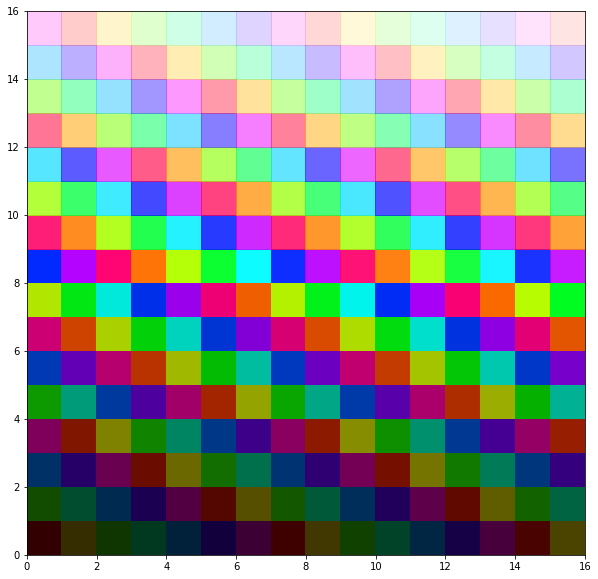

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def generate_colormap(N):
    S = 7
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/S)*S)
    arr.resize(N_up)
    arr = arr.reshape(S,N_up//S).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))


In [ ]:
plt.switch_backend('nbAgg')
Interval = '1D'
SelCol = 'in_app_name'
figsize = (15,8)
data = d0.groupby([pd.Grouper(freq=Interval, key='datetime'), pd.Grouper(key=SelCol)])

data0 = data.filter(lambda t:True)
data = data0.groupby([pd.Grouper(freq=Interval, key='datetime'), pd.Grouper(key=SelCol)])
N_colors = data0[SelCol].value_counts().size
colors = matplotlib.cm.hsv(np.arange(10)/10)
xy_plot = data.size().unstack().plot.bar(stacked=True, rot=45, figsize=figsize, color=colors)
xy_plot.set_xticklabels(xy_plot.get_xticklabels(), ha='right')
xy_plot.get_figure().subplots_adjust(right=0.8)
xy_plot.legend(loc='best', prop={'size': 7}, bbox_to_anchor=(1,0,0.15,1))

In [ ]:
SelCol = 'in_app_name'
data = d0.copy().ffill()

data0 = data
classes = data0[SelCol].value_counts()
sel_classes[]

In [ ]:
d1['in_app_name'].value_counts().size

In [ ]:
interval0 = Dropdown(options=['15min', '30min', '1H', '2H', '3H', '6H', '12H', '1D', '2D', '1W', '1M'], value='1D', description='Bin Interval')

interval0.layout.visibility = 'hidden'
display(interval0)

In [ ]:
# 1. XY-path axis range, add option
# 2. CSV bug, Nikola accessibilityLog
# 3. add option, sorting
# 4. add select column
# 5. show raw data
# %matplotlib notebook
# matplotlib.use('nbAgg')
plt.switch_backend('nbAgg')
matplotlib.get_backend()

# Test

In [ ]:
df = pd.DataFrame({'B':[4,5,4,1,5,4],
                   'C':[7,8,9,4,2,3],
                   'D':[1,3,5,7,1,0],
                   'E':[5,3,6,9,2,4]})

# df1 = df2 = df.copy()
# fig, axes = plt.subplots(nrows=2, ncols=2)
# df1.plot(x='B', y='C', ax=axes[0,0])
# df1.plot(x='B', y='D', ax=axes[0,1])
# df1.plot(x='B', y='E', ax=axes[1,0])
df.plot.bar()

In [ ]:
display(df)
aa=df.groupby('B')

In [ ]:
# xwid = FloatSlider(min=-1, max=1, description='x', continuous_update=False)
# ywid = FloatSlider(min=-1, max=1, description='y', continuous_update=False)
# hbox = HBox([xwid, ywid])

def f(a,b,c,d):
    print(a+b+str(c)+str(d))

w=interactive(f, a=['a', 'b'], b=['1', '2'], c=(0.,10.,0.1), d=False)
VBox([HBox(w.children[0:2]), HBox(w.children[2:4]), w.children[-1]])

